In [22]:
# import required modules
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from shapely.geometry import box
import random

In [23]:
def parse_txt (label_fp, format_bbox, gt_or_pred):
    """Obtain x_min, y_min, x_max, and y_max of bounding box from txt file
    Args:
        label_fp (str): filepath to bounding box .txt file in detect.py output format
        format_bbox: 'x1y1x2y2' or 'xywh_norm' or 'x1y1x2y2_norm'
        gt_or_pred: 'predicted' or 'ground_truth'
    Returns:
        coords (numpy array)
        conf (float, returned only if dataset == 'predicted')
    """
    if format_bbox == 'y1x1y2x2_norm':
        with open(label_fp, 'r') as label:
            line = str(label.readline())
            if len(line) == 0:
                return None
            else:
                vals = line.split(' ')
                x_min = int(float(vals[1]) * 419)
                y_min = int(float(vals[2]) * 419)
                x_max = int(float(vals[3]) * 419)
                y_max = int(float(vals[0]) * 419)
                coords = np.array([y_min, x_min, y_max, x_max])
                if gt_or_pred == 'ground_truth':
                    return coords
                elif gt_or_pred == 'predicted':
                    conf = float(vals[5])
                    conf = '%.4f'%(conf)
                    return coords, conf
    elif format_bbox == 'xywh_norm':
        with open(label_fp, 'r') as label:
            line = str(label.readline())
            if len(line) == 0:
                return None
            else:
                vals = line.split(' ')
                norm_x = float(vals[1])
                norm_y = float(vals[2])
                norm_w = float(vals[3])
                norm_h = float(vals[4])
                x_min = int((norm_x * 419) - ((norm_w * 419) / 2))
                y_min = int((norm_y * 419) - ((norm_h * 419) / 2))
                x_max = int((norm_x * 419) + ((norm_w * 419) / 2))
                y_max = int((norm_y * 419) + ((norm_h * 419) / 2))
                coords = np.array([x_min, y_min, x_max, y_max])
                if gt_or_pred == 'ground_truth':
                    return coords
                elif gt_or_pred == 'predicted':
                    conf = float(vals[5])
                    conf = '%.4f'%(conf)
                    return coords, conf

In [24]:
def calc_IoU (bb1, bb2, gt_format, pred_format):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.
    Adapted from: https://stackoverflow.com/questions/25349178/calculating-percentage-of-bounding-box-overlap-for-image-detector-evaluation
    Args:
        bb1: [x1,y1,x2,y2]
        bb2: [x1,y1,x2,y2]    
    The (x1, y1) position is at the top left corner (or the bottom right - either way works).
    The (x2, y2) position is at the bottom right corner (or the top left).
    Returns:
        intersection_over_union, a float in [0, 1]
    """
    
    # convert to x1y1x2y2 format if needed
    if gt_format == 'y1x1y2x2_norm':
        y_max, x_min, y_min, x_max = bb1
        bb1 = [x_min, y_min, x_max, y_max]
    if pred_format == 'y1x1y2x2_norm':
        y_max, x_min, y_min, x_max = bb2
        bb2 = [x_min, y_min, x_max, y_max]

    # Determine the coordinates of the intersection rectangle
    x_left = max(bb1[0], bb2[0])
    y_top = max(bb1[1], bb2[1])
    x_right = min(bb1[2], bb2[2])
    y_bottom = min(bb1[3], bb2[3])
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    
    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    
    # Compute the area of both AABBs
    bb1_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
    bb2_area = (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])
    
    # Compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the intersection area.
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    
    return iou

In [25]:
def make_results_table (gt_bbox_dir, gt_format, pred_bbox_dir, pred_format, iou_thresholds):
    '''
    Creates dataframe from directories and format for ground truth boxes and predicted boxes. 
    Args:
        gt_bbox_dir: directory of ground truth bounding boxes
        gt_format: format of ground truth bounding boxes 'y1x1y2x2_norm' or 'xywh_norm'
        pred_bbox_dir: directory of ground truth bounding boxes
        pred_format: format of ground truth bounding boxes 'y1x1y2x2_norm' or 'xywh_norm' 
        iou_thresholds: list of floats in (0, 1), i.e. [0.0, 0.2, 0.5, 0.75]
    Returns:
        dataframe with img_id (index), gt_bbox (array), gt_format (string), pred_bbox (array),
        conf, gt_size, iou, and result@iou_thres
    '''
    
    # collect list of filenames
    pred_bbox_fn = os.listdir(pred_bbox_dir)
    gt_bbox_fn = os.listdir(gt_bbox_dir)
    
    # create dictionaries of ground_truth bboxes,  predicted bboxes, and confidence
    ground_truth_dict = {}
    for fn in gt_bbox_fn:
        bbox = parse_txt(os.path.join(gt_bbox_dir, fn), gt_format, 'ground_truth')
        ground_truth_dict[fn] = bbox
    predicted_dict = {}
    conf_dict = {}
    for fn in pred_bbox_fn:
        bbox, conf = parse_txt(os.path.join(pred_bbox_dir, fn), pred_format, 'predicted')
        predicted_dict[fn] = bbox
        conf_dict[fn] = conf
    
    # build dataframe of image, ground_truth bboxes, predicted bboxes, and confidence
    data = {'img_id' : gt_bbox_fn}
    detect_df = pd.DataFrame(data, columns=['img_id'])
    detect_df['img_id'] = detect_df['img_id'].replace('.png', '')
    detect_df['gt_bbox'] = detect_df['img_id'].map(pd.Series(ground_truth_dict))
    detect_df['gt_format'] = 'left/bottom/right/top'
    detect_df['pred_bbox'] = detect_df['img_id'].map(pd.Series(predicted_dict))
    detect_df['pred_format'] = 'top/left/bottom/right'
    detect_df['confidence'] = detect_df['img_id'].map(pd.Series(conf_dict))
    
    # add ground_truth bbox size to dataframe
    detect_df['gt_size'] = detect_df.apply(
        lambda row: None if row.gt_bbox is None else int((row.gt_bbox[2] - row.gt_bbox[0]) * (row.gt_bbox[3] - row.gt_bbox[1])), 
        axis=1
    )
    
    # add IoU - cameratraps to dataframe
    iou_dict = {}
    for fn in predicted_dict:
        if 'not_a_dam' not in fn:
            iou = calc_IoU(ground_truth_dict[fn], predicted_dict[fn], gt_format, pred_format)
            iou_dict[fn] = iou
        else:
            iou_dict[fn] = None
    detect_df['iou'] = detect_df['img_id'].map(pd.Series(iou_dict))
    
    # add result for iou_thres (tp, fp, fn, tn)
    for iou_thres in iou_thresholds:
        detect_df['tp'] = np.where((detect_df.iou > iou_thres), 1, 0)
        detect_df['fp'] = np.where((detect_df.iou <= iou_thres) | (detect_df.pred_bbox.notnull() & detect_df.gt_bbox.isnull()), 1, 0)
        detect_df['fn'] = np.where((detect_df.iou <= iou_thres) | (detect_df.pred_bbox.isnull() & detect_df.gt_bbox.notnull()), 1, 0)
        detect_df['result@IoU'+str(iou_thres)] = detect_df.apply(
            lambda row: 'tp' if row.tp == 1 else 'fp+fn' if (row.fp == 1) & (row.fn == 1) else 'fp' if (row.fp == 1) else 'fn' if (row.fn == 1) else 'tn',
            axis=1
        )
        detect_df = detect_df.drop(['tp', 'fp', 'fn'], axis=1)
    
    # set index to img_id
    detect_df = detect_df.set_index('img_id')
    
    return detect_df

In [26]:
root = '../../..'
gt_bbox_dir = os.path.join(root, 'data/yolov3-inputs_imagery-7-25_cropped_419/validation_set/labels/')
pred_bbox_dir = os.path.join(root, 'outputs/fasterRCNN_07_27_newimagery/export_inference/validationset_inference_fasterRCNN_07_27_newimagery')
gt_format = 'xywh_norm'
pred_format = 'y1x1y2x2_norm'
iou_thresholds = [0.00, 0.05, 0.1, 0.2, 0.5]


detect_df = make_results_table(gt_bbox_dir, gt_format, pred_bbox_dir, pred_format, iou_thresholds)

In [36]:
def visualize_csv (df, gt_bbox_dir, gt_format, pred_bbox_dir, pred_format, images_dir):

    # collect filenames
    gt_bbox_fn = os.listdir(gt_bbox_dir)
    pred_bbox_fn = os.listdir(pred_bbox_dir)
    
    # create dictionaries of ground_truth bboxes,  predicted bboxes, and confidence
    ground_truth_dict = {}
    for fn in gt_bbox_fn:
        bbox = parse_txt(os.path.join(gt_bbox_dir, fn), gt_format, 'ground_truth')
        ground_truth_dict[fn] = bbox
    predicted_dict = {}
    conf_dict = {}
    for fn in pred_bbox_fn:
        bbox, conf = parse_txt(os.path.join(pred_bbox_dir, fn), pred_format, 'predicted')
        predicted_dict[fn] = bbox
        conf_dict[fn] = conf

    # plot
    fig = plt.figure(figsize=(12,240))
    randlist = random.sample(range(0, len(os.listdir(images_dir))), 20)
    k = 0
    for i in randlist:
        img_fn = os.listdir(images_dir)[i]
        txt_fn = img_fn.replace('.png', '.txt')
        k += 1
        if 'not_a_dam' not in img_fn:
            img_fp = os.path.join(images_dir, img_fn)
            img = mpimg.imread(img_fp)
            gt_coords = ground_truth_dict[txt_fn]
            if gt_format == 'xywh_norm':
                gt_bbox = box(gt_coords[0], gt_coords[1], gt_coords[2], gt_coords[3])
            elif gt_format == 'y1x1y2x2_norm':
                gt_bbox = box(gt_coords[1], gt_coords[2], gt_coords[3], gt_coords[0])
            x_gt,y_gt = gt_bbox.exterior.xy
            pred_coords = predicted_dict[txt_fn]
            if pred_format == 'xywh_norm':
                pred_bbox = box(pred_coords[0], pred_coords[1], pred_coords[2], pred_coords[3])
            elif pred_format == 'y1x1y2x2_norm':
                pred_bbox = box(pred_coords[1], pred_coords[2], pred_coords[3], pred_coords[0])
            x_pr,y_pr = pred_bbox.exterior.xy
            img_conf = detect_df.loc[str(txt_fn)]['confidence']
            img_iou = str('%.2f'%(float(detect_df.loc[str(txt_fn)]['iou'])))
            ax = fig.add_subplot(20,1,k)
            ax.set_title(img_fn + '    confidence: ' + img_conf + '    iou: ' + img_iou)
            ax.imshow(img)
            ax.plot(x_gt,y_gt)
            ax.plot(x_pr,y_pr)
        elif 'not_a_dam' in img_fn:
            img_fp = os.path.join(images_dir, img_fn)
            img = mpimg.imread(img_fp)
            ax = fig.add_subplot(20,1,k)
            img_conf = str(detect_df.loc[str(txt_fn)]['confidence'])
            img_iou = str('%.2f'%(float(detect_df.loc[str(txt_fn)]['iou'])))
            ax = fig.add_subplot(20,1,k)
            if len(img_iou) > 0:
                ax.set_title(img_fn + ' conf: ' + img_conf + ' iou: ' + img_iou)
            else:
                ax.set_title(img_fn)
            ax.imshow(img)
        

# ground truth in blue
# predicted in orange

In [40]:
print(detect_df)

                                       gt_bbox              gt_format  \
img_id                                                                  
2672.txt                  [305, 300, 377, 382]  left/bottom/right/top   
125569.txt                [185, 198, 356, 343]  left/bottom/right/top   
125730.txt                 [106, 94, 246, 258]  left/bottom/right/top   
105933.txt                [314, 321, 357, 350]  left/bottom/right/top   
8124.txt                  [176, 192, 220, 204]  left/bottom/right/top   
8382.txt                  [105, 127, 187, 165]  left/bottom/right/top   
124613.txt                [241, 231, 274, 283]  left/bottom/right/top   
6270.txt                  [154, 169, 216, 200]  left/bottom/right/top   
113486.txt                [246, 250, 262, 257]  left/bottom/right/top   
99656.txt                 [106, 130, 198, 174]  left/bottom/right/top   
1453-1169_not_a_dam.txt                   None  left/bottom/right/top   
1656-1197_not_a_dam.txt                   None  lef

In [39]:
# save as csv
detect_df.to_csv(os.path.join(root, 'results/results_validation_fasterRCNN-07-27.csv'))

/data/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


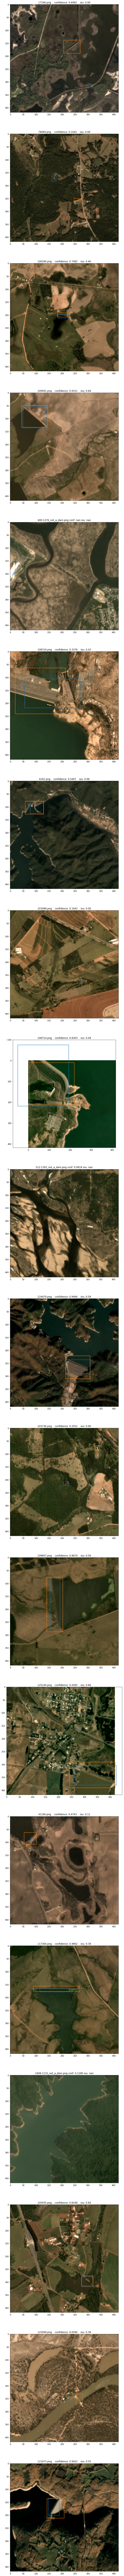

In [37]:
images_dir = os.path.join(root, 'data/yolov3-inputs_imagery-7-25_cropped_419/validation_set/images/')


visualize_csv(detect_df, gt_bbox_dir, gt_format, pred_bbox_dir, pred_format, images_dir)